In [81]:
import re
import random
import pandas as pd
import hashlib

In [82]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].mean() > 80: age_factor = .5
else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1/age_factor) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.05

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [83]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
SharePoint,130.115329,32.528832,38.931440,4
RAG Project,357.682769,22.355173,39.063146,16
Azure AD Authentication,580.618727,44.662979,104.028902,13
IW Migration,595.538134,74.442267,235.451164,8
Asynchronous Python,704.280576,15.310447,28.059884,46
Azure DevOps Pipelines,778.844093,29.955542,97.598902,26
Azure Functions + Visual Studio,849.195390,65.322722,267.737317,13
Email Auth and Security,882.607596,73.550633,187.343422,12
Open Source/GitHub,926.571075,57.910692,170.986406,16
Audit Report Tracker (Sharepoint List),1091.181049,90.931754,364.362366,12


# Histogram

sum of ages: ~39915.93


<Axes: >

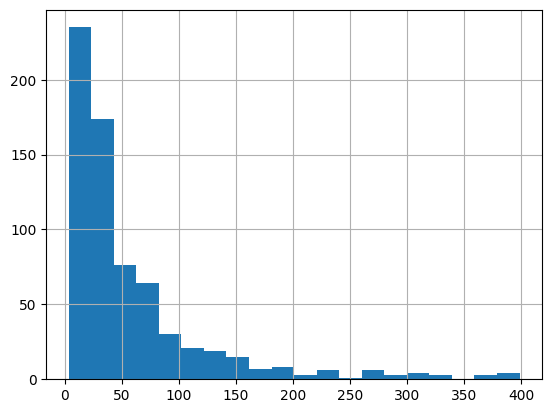

In [84]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [85]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [86]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [87]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

# Focus on one header

In [88]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Header with oldest cards first

In [89]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest mean card age first

In [90]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest age sum first

In [91]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [92]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [93]:
n=3
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)



Cards found: 682
Total card age: 39915.93


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
139,Todd Ideas,"In Azure AI Document Intelligence, all custome...",36fb33cb29b1371aa7384d994d00a992,-395.802872,-114.429888,395.802872,1716.448320,0.028978,0,0
140,Todd Ideas,"In Azure AI Document Intelligence, Custom clas...",7c38d18ca290ac6d6cf9f31852bfe0c9,-157.192755,-114.429888,395.802872,1716.448320,0.028978,3,0
141,Todd Ideas,Connect Document Intelligence via REST APIs wi...,fa2f1bf88811e64ec380482f8e392f8e,-81.081911,-114.429888,395.802872,1716.448320,0.028978,6,0
142,Todd Ideas,"In Azure AI Document Intelligence, prebuilt mo...",9f89fcf65ed6d5dc5f702007d8d74121,-39.848799,-114.429888,395.802872,1716.448320,0.028978,9,0
143,Todd Ideas,"In Azure AI Document Intelligence, prebuilt Do...",4e0c4117f3b9e489fb2df88cb22891ba,-25.939687,-114.429888,395.802872,1716.448320,0.028978,12,0
64,Logging in Python,Q: How can you configure Python's logging to o...,293e680688510b291b7b3691786112ec,-372.540591,-98.451050,372.540591,3445.786752,0.165251,0,0
65,Logging in Python,Q: What is the advantage of using logging.getL...,e63d3ef375f4f0905315b7f337ed7eff,-274.553816,-98.451050,372.540591,3445.786752,0.165251,3,0
66,Logging in Python,Q: How can you include exception tracebacks in...,6a344b1ab62495533fc42ded0c61a8d8,-158.633951,-98.451050,372.540591,3445.786752,0.165251,6,0
67,Logging in Python,Q: Which logging level is appropriate for a me...,34aa335f159554e1fa43ef4942a6303b,-136.580191,-98.451050,372.540591,3445.786752,0.165251,9,0
68,Logging in Python,Q: How can external log rotation tools like lo...,57b27fed5d075e5af65bbc29bdfdbaa4,-125.414310,-98.451050,372.540591,3445.786752,0.165251,12,0


## Age Max

In [94]:
# n = 1
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['age'] = existing_cards['age'] *-1
# # existing_cards.sort_values(['n_fold', 'subject_highest_age', 'age'], inplace=True)
# existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [95]:
# n=10
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)




## Random

In [96]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [97]:
existing_cards.sort_values('age').head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
76,PnP PowerShell,Server Relative URL\nThe URL path relative to ...,8cf299b28aba8eeb49c675bc6fd23204,-398.476831,-45.971779,398.476831,3309.968118,0.441959,0,0
139,Todd Ideas,"In Azure AI Document Intelligence, all custome...",36fb33cb29b1371aa7384d994d00a992,-395.802872,-114.429888,395.802872,1716.448320,0.028978,0,0
160,Debugging in VS Code,Debugger API\nAn application programming inter...,379ed80170d7da4e8ca2e7b1a4b9527c,-391.291150,-72.862701,391.291150,1384.391321,0.609763,0,0
40,Azure Developer Associate,What must be configured on Application Gateway...,8ddf39df1182f81ce6e58790da23ef19,-379.075965,-56.649043,379.075965,3965.433013,0.516079,0,0
313,PnP PowerShell,New-PnPList (PnP.PowerShell)\nCreates a new Sh...,9d9dc3700f5078d8eaff9507709eaacb,-377.279897,-45.971779,398.476831,3309.968118,0.441959,1,1
64,Logging in Python,Q: How can you configure Python's logging to o...,293e680688510b291b7b3691786112ec,-372.540591,-98.451050,372.540591,3445.786752,0.165251,0,0
172,Audit Report Tracker (Sharepoint List),Item (SharePoint List Item)\nDefinition: A sin...,d0ce8d0da3df8f92b4ff3ca95fd426ca,-364.362366,-90.931754,364.362366,1091.181049,0.588477,0,0
278,Azure Developer Associate,Q: Which tiers of Azure Cache for Redis are ba...,1dfb97906449c201f5bdfcd75cba1819,-329.202756,-56.649043,379.075965,3965.433013,0.516079,1,1
22,JavaScript Concepts,Express.js: A minimalist web framework for Nod...,425c10164d26897fdad3f9d7c2c6f523,-328.205743,-70.864631,328.205743,3755.825425,0.197521,0,0
540,PnP PowerShell,AppInv.aspx\nA SharePoint page used to grant a...,ffb4c4ea52b6951b0ba17c6ec30a0956,-327.115392,-45.971779,398.476831,3309.968118,0.441959,2,2


In [98]:
existing_cards.head(10).sum()

head                   Todd IdeasTodd IdeasTodd IdeasTodd IdeasTodd I...
body                   In Azure AI Document Intelligence, all custome...
hash                   36fb33cb29b1371aa7384d994d00a9927c38d18ca290ac...
age                                                         -1767.588883
subject_mean_age                                             -1064.40469
subject_highest_age                                          3841.717317
subject_age_sum                                              25811.17536
head_random_roll                                                0.971143
count                                                                 60
n_fold                                                                 0
dtype: object

In [99]:
existing_cards['age'].mean()

-58.52776077214185